# Building a Naive Bayes Classifier from Scratch

In [27]:
#Import any useful packages
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

After loading in the required packages, the next steps are:

a. Set a seed so that others running this code will get exactly the same results.

b. Read in the data set.

c. Split up the data set into a training set (to give the model something to practice on) and a test set (to evaluate its accuracy).

(Optional) d. Drop the 'ID' column, since ID number is not a predictor variable the way age, race, education, and income are. This is not strictly necessary, but it may make things easier down the line. 

(Optional) e. Print the shape of the test and training data sets to confirm that they contain the desired number of observations.

In [39]:
# Set seed
np.random.seed(4361)

# read in data
turnout_data = pd.read_csv('../turnout.csv')

# Train-Test split (just using Pandas)
train = turnout_data.sample(frac=.8).reset_index(drop=True)
test = turnout_data.drop(train.index).reset_index(drop=True)

#Drop the ID column
train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])
#Move the predictor variable to be the first column in the data frame, just for easier processing
train = train[['vote', 'age', 'educate', 'income', 'white']]
test = test[['vote', 'age', 'educate', 'income', 'white']]
#Just to double check that my train and test sets are the right sizes:
#np.shape(train) = (1600,6)
#np.shape(test) = (400, 6)
#Good to go!

Once the test and training data sets have been created, the next step is to find probabilities. Also, from this point forward, unless explicitly stated otherwise, we are only working with the training data set. 

First, create a variable for the number of observations in the data set. Then choose a variable of interest (in this case, a binary variable indicating whether someone voted in the 2012 elections or not) and calculate the probabilities of each outcome happening (i.e. the probability that any random person recorded in this data set voted, and the probability that any random person did not vote).

In [49]:
#First create a value for the length of the training data set
L = train.shape[0] 
#Next create variables for whether or not someone voted or not
voteY = train.query("vote==1")
voteN = train.query("vote==0")
#Then find the probability that someone voted
pr_voteY = voteY.shape[0]/L #pr_voteY = 0.7425
pr_voteN = voteN.shape[0]/L #pr_voteN = 0.2575

This Bayes classifier is predicated on a Gaussian (normal) distribution. What we want is to find the probability distribution for each other variable in the data set, broken down by outcome for our variable of interest. To do this, we need the mean and standard deviation for each "class." For example, for the variable "age", we want to calculate the mean age and standard deviation of all observations where the person voted and store that in one dictionary entry, and then calculate the mean and standard deviation of all observations where the person did not vote and store that in a separate dictionary entry.

In [38]:
#Next generate a dictionary object with the mean and standard deviation for each variable for each of the two voter outcomes
dist_locs = \
{("age",1):{'mean':voteY.age.mean(),'sd':voteY.age.std()},
 ("age",0):{'mean':voteN.age.mean(),'sd':voteN.age.std()},
 ("educate",1):{'mean':voteY.educate.mean(),'sd':voteY.educate.std()},
 ("educate",0):{'mean':voteN.educate.mean(),'sd':voteN.educate.std()},
 ("income",1):{'mean':voteY.income.mean(), 'sd':voteY.income.std()},
 ("income",0):{'mean':voteN.income.mean(), 'sd':voteN.income.std()},
 ("white",1):{'mean':voteY.white.mean(), 'sd':voteY.white.std()},
 ("white",0):{'mean':voteN.white.mean(), 'sd':voteN.white.std()}
}
# Print
#pp.pprint(dist_locs)

Using seaborn, it is possible to view the probability distributions for our 8 classes (4 predictor variables for each of two possible outcomes). These variables operate on different scales, so expanding the x-axis range to go from -10 to 90 makes it easier to see and interpret all of the curves.

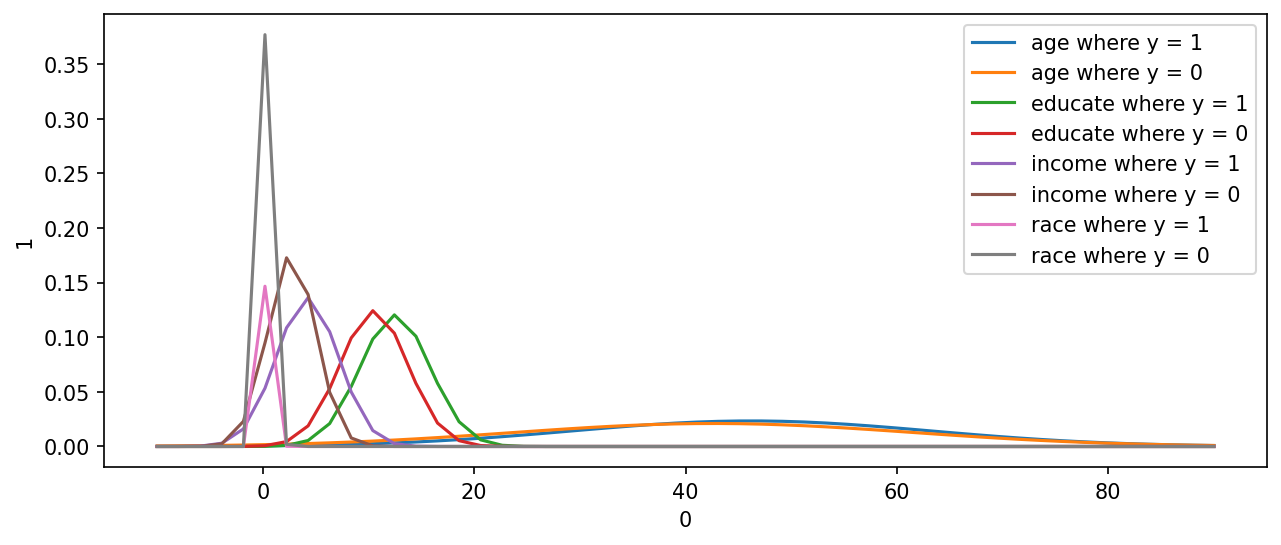

In [32]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,90)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

Ok, so we have our means and standard deviations for each class. Now we need a function that can categorize each observation based on whether it has a higher probability of "vote = 1" or "vote = 0" (meaning whether it is more likely that the person recorded in a specific observation did or did not vote).

In [44]:
def predict(data,dist_locs):
    '''
    Predicts which of two outcomes is more likely for a given observation given means and standard deviations.
    Returns a data frame consisting of the probability of each outcome for the observation and the predicted outcome.
    Arguments:
                data: a data set
                dist_locs: a dictionary object of means and standard deviations for different classes of predictor
                           and outcome variables
    '''
    #Start a new list object
    store_preds = []
    #Iterate through the data specified by the data argument
    for i,row in data.iterrows():
        
        #Get the predictions using a Gaussian distribution
        pr_0 = 1; pr_1 = 1
        
        #Using the probability density functions specified by the means and standard deviations from the
        #dist_locs argument, find the probability that an observation has an expected value of 0 for the outcome
        #variable, as well as the probability that it has an expected value of 1. 
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        
        #Multiply by the known probabilities of each possible outcome    
        pr_0 *= pr_voteN
        pr_1 *= pr_voteY
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
        #Append the columns for the probability of an observation's class being 0, the probability of it being 1, and the
        #predicted class to the list object created earlier in the function
        store_preds.append([pr_0,pr_1,class_pred])
    #Return that list object    
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

We've got our training data set, we've got our test data set, and we've got our classifier function. Let's see how accurate this predictor turns out to be. First, run the function on the training data set and store the output.

In [46]:
bayes_train = predict(train,dist_locs)

Now let's test for accuracy. To do this, we find the number of observations where the value for "vote" (the true outcome) is the same as the value for "pred" (the predicted outcome). Then, just divide that by the number of observations to get the probability that this classifier would correctly predict whether or not someone voted in the 2012 elections. I'm also multiplying the accuracy value by 100, so I can express it as a percentage, but this isn't necessary. 

In [62]:
#L is the length of the data set, which was defined earlier.
accuracy_train = sum(train.vote == bayes_train.pred)/L
print("This classifier correctly predicted whether a person in the training data set voted in the 2012 elections  \nor not",
      (accuracy_train*100), "% of the time.")

This classifier correctly predicted whether a person in the training data set voted in the 2012 elections  
or not 72.8125 % of the time.


72.81% means this classifier correctly predicts a person's participation in the 2012 elections about 3 times out of 4. Let's see how it does with the test data.

In [66]:
bayes_test = predict(test,dist_locs)
accuracy_test = sum(test.vote == bayes_test.pred)/L
print("This classifier correctly predicted whether a person in the test data set voted \nin the 2012 elections or not",
      (accuracy_train*100), "% of the time.")

This classifier correctly predicted whether a person in the test data set voted 
in the 2012 elections or not 72.8125 % of the time.


To visualize the performance of this classifier, we can plot its ROC curve.

In [68]:
#Organize the data so the sklearn package can more easily use it 
train_y = train['vote']
train_x = train[['age','educate','income','white']]
test_y = test['vote']
test_x = test[['age','educate','income','white']]

In [73]:
#Import some things from the sklearn package
from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics as m 

#Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train the classifier on the training set

#Generate predictions 
y_pred = gnb.predict(test_x)

In [70]:
#Generate probabilities using the test data
probs = gnb.predict_proba(test_x)

#Convert those probabilities to a data frame
probs =  pd.DataFrame(probs,columns=gnb.classes_)

In [71]:
#Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

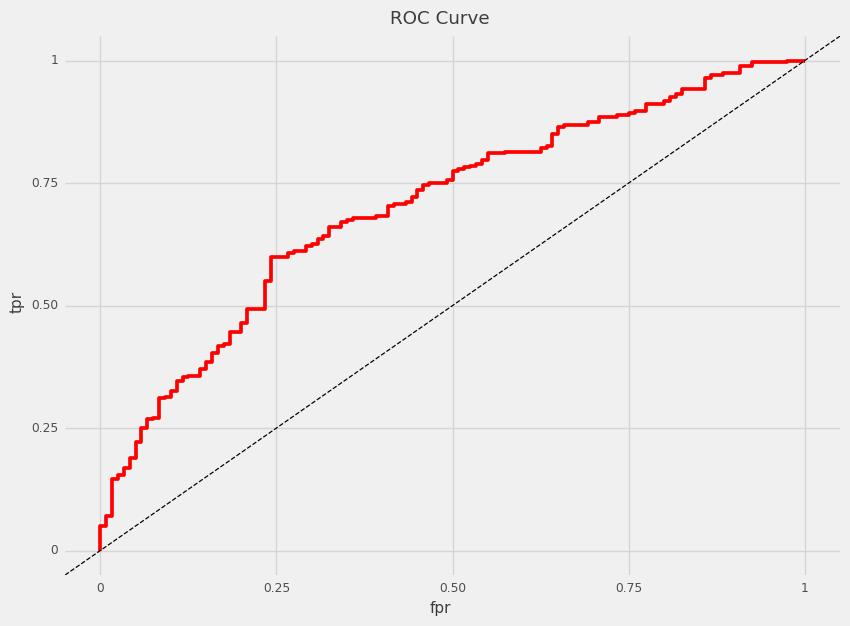

<ggplot: (140801094352)>

In [78]:
#Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="red",size=1.5) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_538() +
    labs(title="ROC Curve") +
    theme(figure_size=(10,7))
)

#### What does this ROC curve indicate?

If this classifier had an accuracy rate of 50%, this ROC curve would look like the dashed line. Since the curve is not linear, this classifier is more accurate than a standard coin flip. This makes sense given the accuracy rate of 72.81% determined earlier. 

Based on the data available, this naive Bayes classifier is capable of taking information about a person's age, total number of years spent in school, income, and race, and accurately predicting whether or not they voted in the 2012 United States general election 72.81% of the time. More specific data, such as information on race which goes beyond white/nonwhite, could increase the classifier's accuracy.